In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np
from pycocotools.coco import COCO
import torch
import cv2
import json
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

from augmentation import CustomElasticAugmentation, CustomAugmentation

In [2]:
dataset_path = '../data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [3]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

category_names = list(sorted_df.Categories)

loading annotations into memory...
Done (t=4.01s)
creating index...
index created!
image shape: [512, 512, 3]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {9, 'Plastic bag'}]


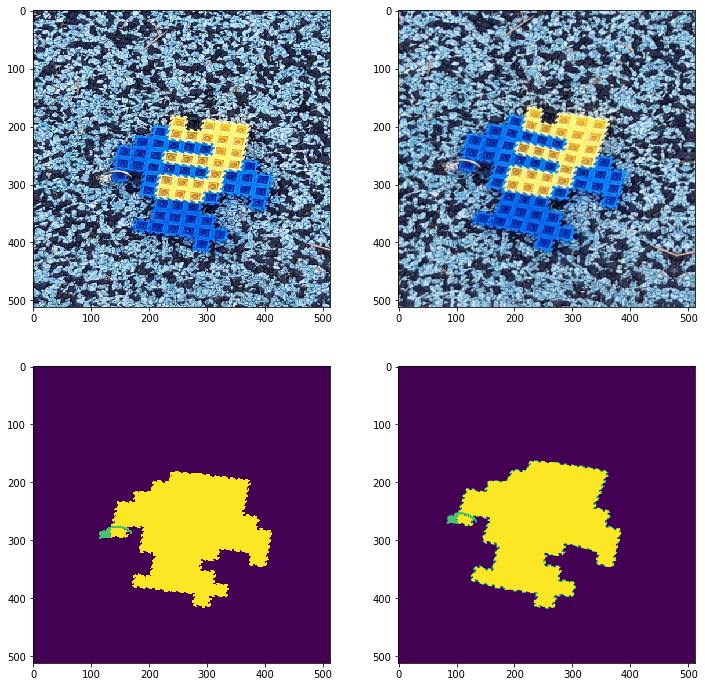

In [4]:
train_path = dataset_path + '/train.json'

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

def collate_fn(batch):
    return tuple(zip(*batch))

transform_elastic = CustomElasticAugmentation()
# transform_elastic = CustomAugmentation()


transform_basic = A.Compose([
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=4,
                                           shuffle=False,
                                           num_workers=0,
                                           collate_fn=collate_fn)

for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

num = 2

dict1 = transform_basic(image=temp_images[num], mask=temp_masks[num])
dict2 = transform_elastic(image=temp_images[num], mask=temp_masks[num])

img1, mask1, img2, mask2 = dict1['image'], dict1['mask'], dict2['image'], dict2['mask']

ax1.imshow(img1.permute([1,2,0]))
ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(img2.permute([1,2,0]))
ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

ax3.imshow(mask1)
ax3.grid(False)

ax4.imshow(mask2)
ax4.grid(False)

plt.show()

In [5]:
print(torch.sum(img1 != img2))
print(torch.sum(img1 == img2))

tensor(786395)
tensor(37)


In [6]:
print(torch.sum(mask1 != mask2))
print(torch.sum(mask1 == mask2))

tensor(22601)
tensor(239543)


In [7]:
temp_masks[0].shape

(512, 512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


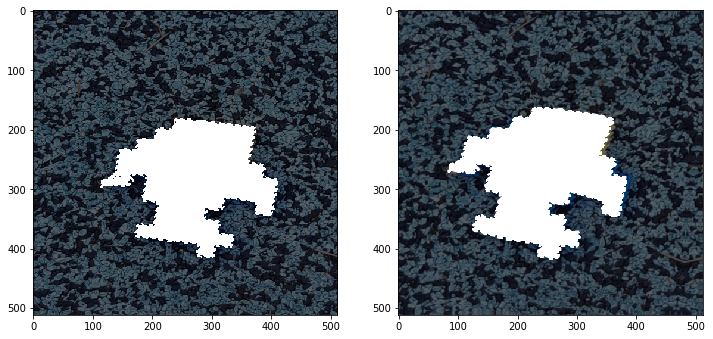

In [8]:
COLORS =[
        [129, 236, 236],
        [2, 132, 227],
        [232, 67, 147],
        [255, 234, 267],
        [0, 184, 148],
        [85, 239, 196],
        [48, 51, 107],
        [255, 159, 26],
        [255, 204, 204],
        [179, 57, 57],
        [248, 243, 212],
    ]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

output1 = ((0.4 * img1) + (0.6 * mask1))
output2 = ((0.4 * img2) + (0.6 * mask2))

ax1.imshow(output1.permute([1, 2, 0]))
ax2.imshow(output2.permute([1, 2, 0]))

plt.show()

